In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from train import *
from tqdm.auto import trange
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Stateful Lstm

In [3]:
data = pd.read_csv("data/final.csv")

data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
data.head()
m_data = data.copy()
m2_data = data.copy()
patch_data = data.copy()
tst_size = 20

In [4]:
# 변수 초기화

#Lstm
state_input_size = 2     #고정
state_hidden_size = 32
state_output_size = 2     #고정
state_num_layers = 2
state_batch_size = 128

In [5]:
statefullstm = StatefulLoadData(data,tst_size)
state_trn_scaled, state_tst_scaled = statefullstm.scaling()
#trn_scaled, tst_scaled

In [6]:
trn, tst = data[:-tst_size], data[-tst_size:]

In [7]:
statefulmodel = StatefulLSTM(state_input_size,state_hidden_size,state_output_size,state_num_layers)
statefulmodel.to(device)

StatefulLSTM(
  (rnn): LSTM(2, 32, num_layers=2)
  (head): Linear(in_features=32, out_features=2, bias=True)
)

In [8]:
trn_x = torch.tensor(state_trn_scaled[:-1]).split(state_batch_size)
trn_y = torch.tensor(state_trn_scaled[1:]).split(state_batch_size)
tst_y = torch.tensor(state_tst_scaled)

In [9]:
state_optim = torch.optim.AdamW(statefulmodel.parameters(), lr=0.0001)

p=state_train_epoch(statefulmodel, 10 , device, zip(trn_x,trn_y), state_optim, tst_y)
#map , filter, zip

'''
pbar = trange(50)
for e in pbar:
  statefulmodel.train()
  statefulmodel.reset_state()
  trn_loss = .0
  for x, y in zip(trn_x, trn_y):
    x, y = x.to(device), y.to(device)
    state_optim.zero_grad()
    p = statefulmodel(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    state_optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  statefulmodel.eval()
  with torch.inference_mode():
    p = statefulmodel.predict(y[-1:].to(device), len(tst_y))
    tst_loss = F.mse_loss(p, tst_y.to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})
'''

  0%|          | 0/10 [00:00<?, ?it/s]

"\npbar = trange(50)\nfor e in pbar:\n  statefulmodel.train()\n  statefulmodel.reset_state()\n  trn_loss = .0\n  for x, y in zip(trn_x, trn_y):\n    x, y = x.to(device), y.to(device)\n    state_optim.zero_grad()\n    p = statefulmodel(x)\n    loss = F.mse_loss(p, y)\n    loss.backward()\n    state_optim.step()\n    trn_loss += loss.item()\n  trn_loss /= len(trn)-1\n\n  statefulmodel.eval()\n  with torch.inference_mode():\n    p = statefulmodel.predict(y[-1:].to(device), len(tst_y))\n    tst_loss = F.mse_loss(p, tst_y.to(device)).item()\n  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})\n"

In [10]:
scaler = statefullstm.get_scaler()
prd = scaler.inverse_transform(p.cpu()[:,:1])

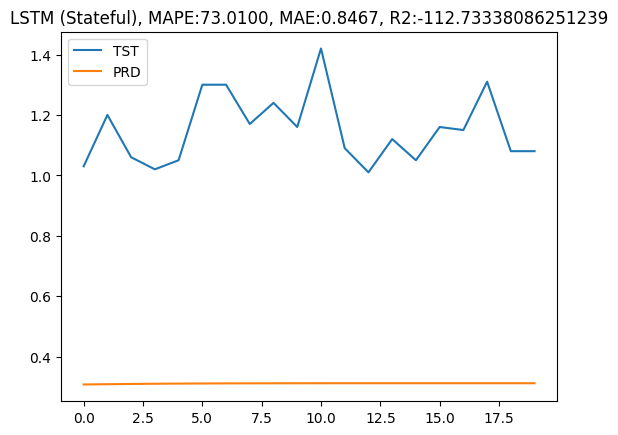

In [11]:
plt.title(f"LSTM (Stateful), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.Temperature.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

In [12]:
torch.save(statefulmodel.state_dict(), './AdamW_0.002_StatefulLstm.pth')

# Stateless Lstm

In [13]:
stateless_window_size = 64
stateless_input_size = 2
stateless_hidden_size = 32
stateless_output_size = 2
stateless_num_layers = 2

asdf = StatelessLoadData(data, tst_size, stateless_window_size)
stateless_trn_dl , stateless_tst_dl = asdf.scaling()

In [14]:
statelesslstm = StatelessLSTM(stateless_input_size , stateless_hidden_size , stateless_output_size , stateless_num_layers)
statelesslstm.to(device)

StatelessLSTM(
  (rnn): LSTM(2, 32, num_layers=2, batch_first=True)
  (head): Linear(in_features=32, out_features=2, bias=True)
)

In [15]:
x,y =next(iter(stateless_trn_dl))
x.shape,y.shape

(torch.Size([64, 64, 2]), torch.Size([64, 64, 2]))

In [16]:
optim = torch.optim.AdamW(statelesslstm.parameters(), lr=0.0001)
p2 = stateless_train_epoch(statelesslstm,10,device,stateless_trn_dl,optim,stateless_tst_dl, state_tst_scaled)
'''
pbar = trange(50)
for e in pbar:
  statelesslstm.train()
  trn_loss = .0
  for x, y in stateless_trn_dl:
    #print(x.shape, y.shape)
    #print(y)
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = statelesslstm(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()

  trn_loss /= len(trn)-1

  statelesslstm.eval()
  with torch.inference_mode():
    x, y = next(iter(stateless_tst_dl))
    p = statelesslstm.predict(x[0].to(device), len(state_tst_scaled))[:,:1]
    tst_loss = F.mse_loss(p, torch.tensor(state_tst_scaled[:,:1]).view(-1,1).to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})
'''

  0%|          | 0/10 [00:00<?, ?it/s]

"\npbar = trange(50)\nfor e in pbar:\n  statelesslstm.train()\n  trn_loss = .0\n  for x, y in stateless_trn_dl:\n    #print(x.shape, y.shape)\n    #print(y)\n    x, y = x.to(device), y.to(device)\n    optim.zero_grad()\n    p = statelesslstm(x)\n    loss = F.mse_loss(p, y)\n    loss.backward()\n    optim.step()\n    trn_loss += loss.item()\n\n  trn_loss /= len(trn)-1\n\n  statelesslstm.eval()\n  with torch.inference_mode():\n    x, y = next(iter(stateless_tst_dl))\n    p = statelesslstm.predict(x[0].to(device), len(state_tst_scaled))[:,:1]\n    tst_loss = F.mse_loss(p, torch.tensor(state_tst_scaled[:,:1]).view(-1,1).to(device)).item()\n  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})\n"

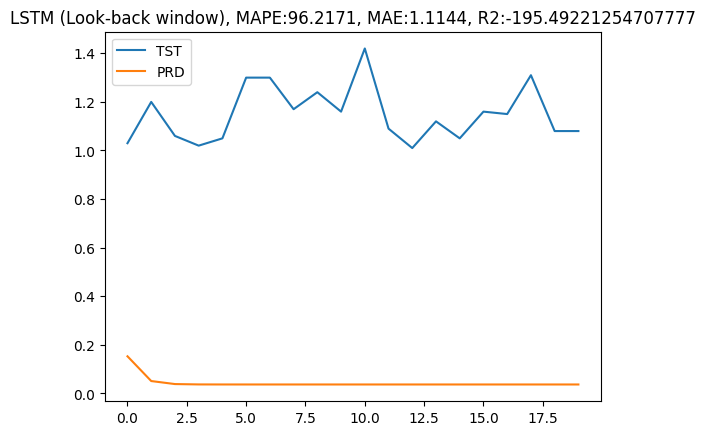

In [17]:
scaler = asdf.get_scaler()
prd = scaler.inverse_transform(p2.cpu())
# prd = p.cpu()

plt.title(f"LSTM (Look-back window), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.to_numpy()[:,:1], label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

# Single ANN

In [18]:
# dataset params
single_lookback_size = 24
single_forcast_size = 4 
single_batch_size = 32

# model params
single_d_in = 24
single_d_out = 4 
single_d_hidden = 512

anndataset = ANNLoadData(m_data,single_lookback_size,single_forcast_size,tst_size,single_batch_size)

single_trn_dl , single_tst_dl, single_trn_ds = anndataset.scaling()

In [19]:
singleann = Net(single_d_in,single_d_out,single_d_hidden)

In [20]:
x, y = next(iter(single_trn_dl))

x.shape, y.shape

(torch.Size([32, 24]), torch.Size([32, 4]))

In [21]:
singleann.to(device)
optim = torch.optim.AdamW(singleann.parameters(), lr=0.0001)
p3 = train_epoch(singleann , 500 , device, single_trn_dl, optim, single_trn_ds, single_tst_dl)
'''
pbar = trange(1000)
for i in pbar:
  singleann.train()
  trn_loss = .0
  for x, y in single_trn_dl:
    x, y = x.to(device), y.to(device)
    #print(x,y)
    p = singleann(x)
    #print(p)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    #print(loss)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(single_trn_ds)

  singleann.eval()
  with torch.inference_mode():
    x, y = next(iter(single_tst_dl))
    x, y = x.to(device), y.to(device)
    p = singleann(x)
    tst_loss = F.mse_loss(p,y)
    # tst_mape = mape(p,y)
    # tst_mae = mae(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})#, 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})
  '''

  0%|          | 0/500 [00:00<?, ?it/s]

"\npbar = trange(1000)\nfor i in pbar:\n  singleann.train()\n  trn_loss = .0\n  for x, y in single_trn_dl:\n    x, y = x.to(device), y.to(device)\n    #print(x,y)\n    p = singleann(x)\n    #print(p)\n    optim.zero_grad()\n    loss = F.mse_loss(p, y)\n    #print(loss)\n    loss.backward()\n    optim.step()\n    trn_loss += loss.item()*len(y)\n  trn_loss = trn_loss/len(single_trn_ds)\n\n  singleann.eval()\n  with torch.inference_mode():\n    x, y = next(iter(single_tst_dl))\n    x, y = x.to(device), y.to(device)\n    p = singleann(x)\n    tst_loss = F.mse_loss(p,y)\n    # tst_mape = mape(p,y)\n    # tst_mae = mae(p,y)\n  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})#, 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})\n  "

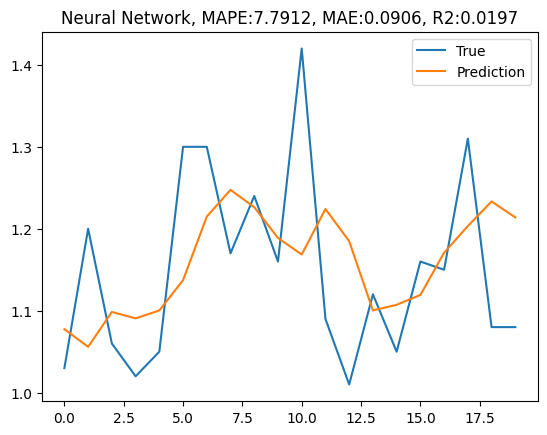

In [26]:
singleann.eval()
with torch.inference_mode():
  x, y = next(iter(single_tst_dl))
  x, y = x.to(device), y.to(device)
  p = singleann(x)

scaler = anndataset.get_scaler()
y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

res_dict = {}

plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9,512,4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

MAPE:  8.800041406289923
MAE:  0.1000225920677185
R2_Score:  -0.07329892994969267


<Axes: xlabel='YearMonth'>

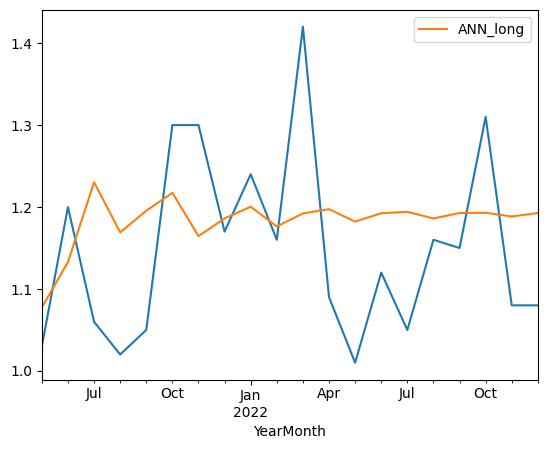

In [27]:
# 장기예측
window_size = single_lookback_size
prediction_size = single_forcast_size
preds = []
tst_data  = data [-tst_size :]

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
singleann.to(device)

# print(type(x), type(y))
x, y = single_trn_ds[len(single_trn_ds)-1]

for _ in range(tst_size):
  #print(x.shape, y.shape)
  y=y.squeeze()
  #print(x.shape, y.shape)

  x = np.concatenate([x,y])[-window_size:]
  #x = x.flatten()
  #y = y.flatten()
    
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  #y = net(torch.tensor(x, dtype=torch.float32).to(device)) # your model
  y=singleann(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scaler.inverse_transform(preds).squeeze()
#print(preds.shape)
preds = preds[:,0]
#print(preds.shape)

mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": preds}, index=tst_data.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

# Multichannel ANN

In [28]:
#Multi Load Data
multi_lookback_size = 24
multi_forecast_size = 4
multi_batch_size = 32
multi_window_size = 24
# prediction_size = 4 여기 사용안하는것 같에요

# Multi model
multi_input_size = multi_lookback_size   #고정
multi_hidden_size = 512
multi_output_size = multi_forecast_size     #고정
multi_channel_size = 3

In [29]:
m_data = data.copy()
m2_data['rolling_mean'] = m2_data.rolling(12).mean()
m2_data['diff1'] = m2_data['Temperature'].diff(1)
m2_data = m2_data.dropna()

multidata = MultiANNLoadData(m2_data,multi_lookback_size,multi_forecast_size,tst_size,multi_batch_size)
multi_trn_dl, multi_tst_dl , multi_trn_ds = multidata.scaling()

In [30]:
multimodel = NetMulti(multi_lookback_size,multi_output_size,multi_hidden_size,multi_channel_size)

- 40개월   ex) 60을 보고 40을 예측  /  1개월씩 40을 예측  /  4개월씩 10번
- 목표를 설정하고 그것을 이루기 위해 시도한 방법들 소개!

In [31]:
multimodel.cuda()

optim = torch.optim.AdamW(multimodel.parameters(), lr=0.0001)
train_epoch(multimodel,100,device,multi_trn_dl,optim,multi_trn_ds, multi_tst_dl)

'''
pbar = trange(1000)
for i in pbar:
  multimodel.train()
  trn_loss = .0
  for x, y in multi_trn_dl:
    x, y = x.to(device), y.to(device)   # (32, 24, 3), (32, 4, 3)
    #print(x.shape, y.shape)
    p = multimodel(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(multi_trn_ds)

  multimodel.eval()
  with torch.inference_mode():
    x, y = next(iter(multi_tst_dl))
    x, y = x.to(device), y.to(device)
    p = multimodel(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})
'''

  0%|          | 0/100 [00:00<?, ?it/s]

"\npbar = trange(1000)\nfor i in pbar:\n  multimodel.train()\n  trn_loss = .0\n  for x, y in multi_trn_dl:\n    x, y = x.to(device), y.to(device)   # (32, 24, 3), (32, 4, 3)\n    #print(x.shape, y.shape)\n    p = multimodel(x)\n    optim.zero_grad()\n    loss = F.mse_loss(p, y)\n    loss.backward()\n    optim.step()\n    trn_loss += loss.item()*len(y)\n  trn_loss = trn_loss/len(multi_trn_ds)\n\n  multimodel.eval()\n  with torch.inference_mode():\n    x, y = next(iter(multi_tst_dl))\n    x, y = x.to(device), y.to(device)\n    p = multimodel(x)\n    tst_loss = F.mse_loss(p,y)\n  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})\n"

# 단기

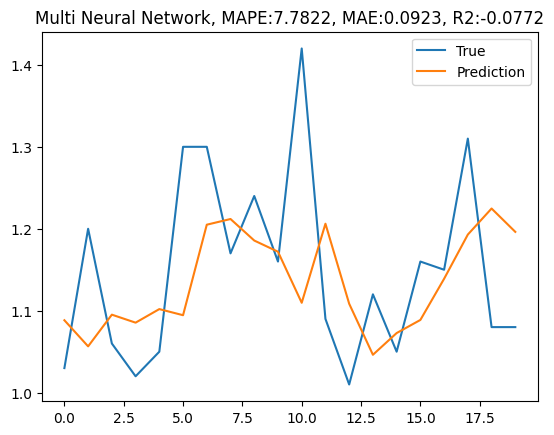

In [32]:
scaler = multidata.get_scaler()
res_dict = {}

multimodel.eval()
multimodel.to('cuda')
with torch.inference_mode():
  x, y = next(iter(multi_tst_dl))
  #print(y.shape) #17,4,3
  y=y.reshape(-1,multi_channel_size)
  y=scaler.inverse_transform(y.cpu().numpy())
  y=y.reshape(-1,multi_forecast_size,multi_channel_size)
  x, y = x.flatten(1), y[:,:,0] #17,4    0번째 채널을 뽑고있다.

  x = x.to('cuda')
  #p = Multinet(x)[:,:,0]
  p = multimodel(x)
  #print(p.shape)
  p = p.reshape(-1,multi_channel_size)
  p=p.cpu()
  p=scaler.inverse_transform(p.numpy())
  #print(p.shape)
  p = p.reshape(-1,multi_forecast_size,multi_channel_size)

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])
#print(y,p)
#print(y.shape,p.shape)
p = p[:,0]
#inverse_preds = scaler.inverse_transform(p.reshape(-1,3))


plt.title(f"Multi Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9*2, 512, 4)': {'MAPE':mape(p,y), 'MAE':mae(p,y),  'R2':r2_score(p,y)}})

# 장기

In [33]:
# 장기예측
window_size = multi_lookback_size
prediction_size = multi_forecast_size
preds = []
multimodel.to(device)

# print(type(x), type(y))
x, y = multi_trn_ds[len(multi_trn_ds)-1]
print(y)
print(x.shape , y.shape)

[[0.8028985  0.96783626 0.49456525]
 [0.71304345 0.93650794 0.30978262]
 [0.7855072  0.9177109  0.6141305 ]
 [0.76231885 0.90601504 0.43478262]]
(24, 3) (4, 3)


(20,)
MAPE:  20.627684059615355
MAE:  0.2414915200471878
R2_Score:  -5.688586550282754


<Axes: xlabel='YearMonth'>

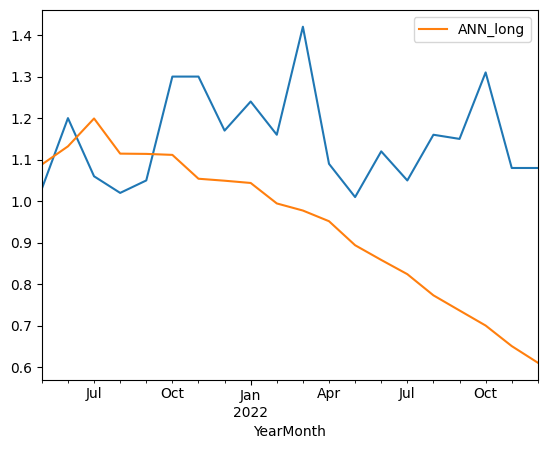

In [34]:
preds = []

for i in range(tst_size):
  y = y.squeeze()
  # print(i, x.shape, y.shape)
  x = np.concatenate([x,y])[-window_size:]
    
  x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
  # print(x_tensor.shape)
  y = multimodel(x_tensor)
  # print(y.shape)
  y = y.detach().cpu().numpy()
  # y = y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)
  # print(i, x.shape, y.shape)

preds = np.concatenate(preds, axis=0)
inverse_preds = scaler.inverse_transform(preds.reshape(-1,3)).reshape(-1,4,3)

final_preds = inverse_preds[:, 0,0]
print(final_preds.shape)

mape2 = mape(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(final_preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": final_preds}, index=tst.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

# PatchTST

In [35]:
#초기화
patch_size = 4 #고정
n_patch = 12
n_token = 6   #고정
patch_batch_size = 32
patch_model_dim = 512
patch_num_heads = 8   #고정
patch_num_layers = 4   #고정
patch_output_dim = 4   #고정

In [36]:
patchdata = PatchLoadData(patch_data,patch_size,n_patch,n_token,tst_size,patch_batch_size)

patch_trn_dl , patch_tst_dl, patch_trn_ds = patchdata.scaling()

In [37]:
patchmodel = PatchTST(n_token, patch_size * n_patch , patch_model_dim, patch_num_heads, patch_num_layers, patch_output_dim)
patchmodel.cuda()

PatchTST(
  (patch_embedding): Linear(in_features=48, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=3072, out_features=4, bias=True)
)

In [38]:
optim = torch.optim.AdamW(patchmodel.parameters(), lr=0.0001)
train_epoch(patchmodel,100,device,patch_trn_dl,optim,patch_trn_ds, patch_tst_dl)

'''pbar = trange(100)
for _ in pbar:
  patchmodel.train()
  trn_loss = 0.
  for x,y in patch_trn_dl:
    x, y = x.cuda(), y.cuda()
    p = patchmodel(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(x)
  trn_loss = trn_loss / len(patch_trn_ds)

  patchmodel.eval()
  with torch.inference_mode():
    x, y = next(iter(patch_tst_dl))
    x, y = x.cuda(), y.cuda()
    p = patchmodel(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})
  '''

  0%|          | 0/100 [00:00<?, ?it/s]

"pbar = trange(100)\nfor _ in pbar:\n  patchmodel.train()\n  trn_loss = 0.\n  for x,y in patch_trn_dl:\n    x, y = x.cuda(), y.cuda()\n    p = patchmodel(x)\n    optim.zero_grad()\n    loss = F.mse_loss(p, y)\n    loss.backward()\n    optim.step()\n    trn_loss += loss.item()*len(x)\n  trn_loss = trn_loss / len(patch_trn_ds)\n\n  patchmodel.eval()\n  with torch.inference_mode():\n    x, y = next(iter(patch_tst_dl))\n    x, y = x.cuda(), y.cuda()\n    p = patchmodel(x)\n    tst_loss = F.mse_loss(p,y)\n  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})\n  "

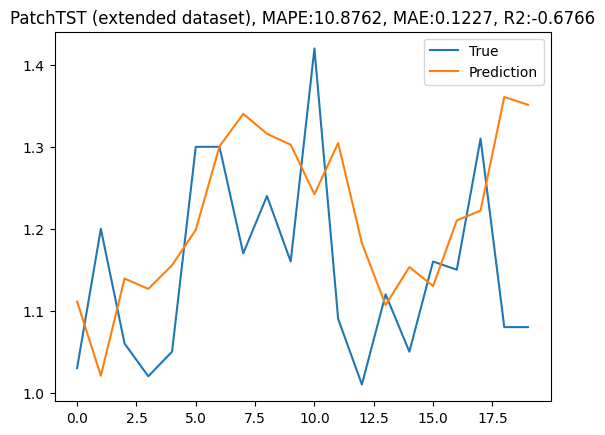

In [39]:
scaler = patchdata.get_scaler()

patchmodel.eval()
with torch.inference_mode():
  x, y = next(iter(patch_tst_dl))
  x, y = x.cuda(), y.cuda()
  p = patchmodel(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST (extended dataset), MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

MAPE:  17.014533780487547
MAE:  0.1878247721195221
R2_Score:  -2.4024477609479025


<Axes: xlabel='YearMonth'>

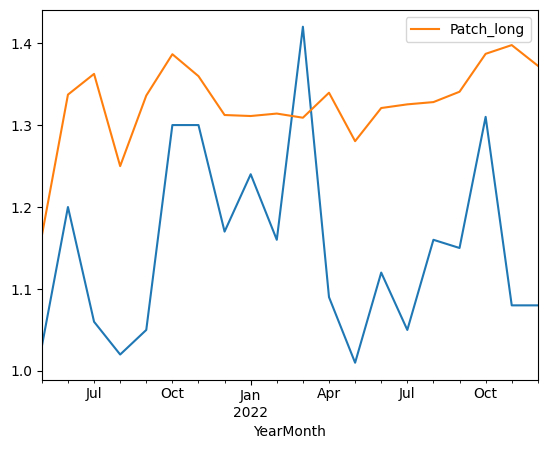

In [40]:
# 장기예측 
window_size = n_token * n_patch * patch_size
prediction_size = patch_size
preds = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
patchmodel.to(device)

# print(type(x), type(y))
x, y = patch_trn_ds[len(patch_trn_ds)-1]

for _ in range(tst_size):
  #print(x, y)
  #y=y.squeeze()
  #print(x.shape, y.shape) #(6,16),(4,) (24,3)/(4,3)
  x = x.flatten()
  y = y.flatten()
  #print(x, y)
  #print(x.shape, y.shape) #(96,),(4,)
  
  x = np.concatenate([x,y])[-window_size:]
  x = x.reshape(1, n_token, -1) 
  #print(x.shape)

  #y = y.flatten()
  
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  #y = net(torch.tensor(x, dtype=torch.float32).to(device)) # your model
  y=patchmodel(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scaler.inverse_transform(preds).squeeze()
#print(preds.shape)
preds = preds[:,0]

mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
#plt.title(f"PatchTST (extended dataset), MAPE:{mape(preds,data.Temperature[-20:].to_numpy()):.4f}, MAE:{mae(preds,data.Temperature[-20:].to_numpy()):.4f}, R2:{r2_score(preds,data.Temperature[-20:].to_numpy())(p,y):.4f}")
df = pd.DataFrame({"Patch_long": preds}, index=tst.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)